<a href="https://colab.research.google.com/github/drewm8080/ITP-449-Lectures/blob/main/ITP449_Time_Series_(Part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA

We will create an ARIMA Model for Time Series Forecasting in Python.

ARIMA is a widely used statistical method for analyzing and forecasting time series data. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. 

It consists of a suite of standard structures in time series data and provides a simple yet powerful method for making skillful time series forecasts.

**AR: Autoregression.** A model that uses the dependent relationship between an observation and some number of lagged observations.

**I: Integrated.** The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA: Moving Average.** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

**p:** The number of lag observations included in the model, also called the lag order.

**d:** The number of times that the raw observations are differenced, also called the degree of differencing.

**q:** The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.


### Using the ARIMA model in Python

The Dataset - **Shampoo Sales Dataset**

This dataset describes the monthly number of sales of shampoo over a 3 year period.

There are 36 observations

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# function used in next cell to parse date in particular format

# We are baselining the dataset in an arbitrary year (2000 in our case)
def parser(x):
  return datetime.strptime('200'+x, '%Y-%m')

Month
2001-01-01    266.0
2001-02-01    145.9
2001-03-01    183.1
2001-04-01    119.3
2001-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


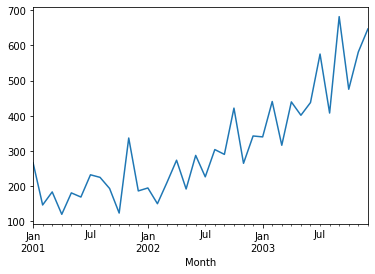

In [ ]:
# read data, convert the date to right format
# plot data as a time series with the month along the x-axis and sales figures on the y-axis
data = pd.read_csv('shampoo.csv', header=0, index_col=0, parse_dates=[0], squeeze=True, date_parser=parser)
print(data.head())

data.plot()
plt.show()

Notice that the Shampoo Sales dataset has a clear trend. 

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Plot the autocorrelation for a large number of lags in the time series.

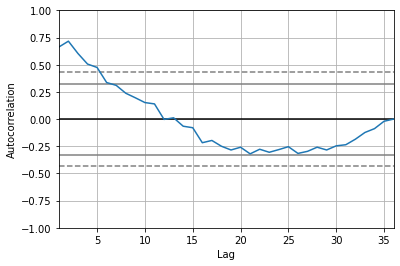

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data)
plt.show()

We can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the **AR** parameter of the model may be 5.

An ARIMA model can be created using the statsmodels library as follows:

- Define the model by calling ARIMA() and passing in the p, d, and q parameters.
- The model is prepared on the training data by calling the fit() function.
- Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Tue, 16 Feb 2021   AIC                            406.340
Time:                                                 18:16:34   BIC                            417.227
Sample:                                             02-01-2001   HQIC                           410.098
                                                  - 12-01-2003                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

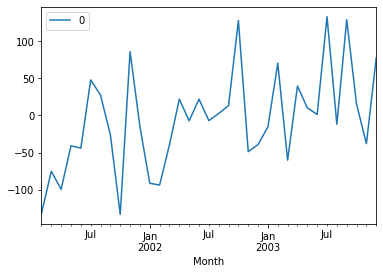

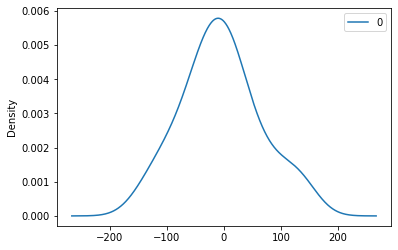

                0
count   35.000000
mean    -5.495223
std     68.132882
min   -133.296638
25%    -42.477902
50%     -7.186558
75%     24.748322
max    133.237947


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

#data.index = data.index.to_period('M')

# fit model
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

# We get a line plot of the residual errors, 
# suggesting that there may still be some trend information not captured by the model.

# We also get a density plot of the residual error values, 
# suggesting the errors are Gaussian, but may not be centered on zero.

# Finally, distribution of the residual errors is displayed. 
# The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Note - although we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

### Rolling Forecast ARIMA Model

ARIMA model can be used to forecast future time stamps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Running the example prints the prediction and expected value each iteration.

We can also calculate a final root mean squared error score (RMSE) for the predictions, providing a point of comparison for other ARIMA configurations.

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

The model could use further tuning of the p, d, and maybe even the q parameters.

predicted=349.117773, expected=342.300000
predicted=306.512989, expected=339.700000
predicted=387.376418, expected=440.400000
predicted=348.154132, expected=315.900000
predicted=386.308780, expected=439.300000
predicted=356.082032, expected=401.300000
predicted=446.379500, expected=437.400000
predicted=394.737242, expected=575.500000
predicted=434.915524, expected=407.600000
predicted=507.923412, expected=682.000000
predicted=435.482873, expected=475.300000
predicted=652.743762, expected=581.300000
predicted=546.343510, expected=646.900000
Test RMSE: 83.417


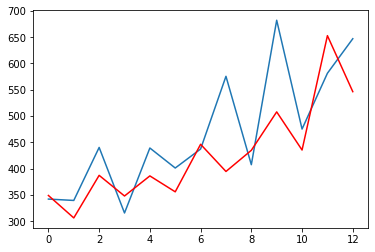

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Prophet

Prophet library is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

NOTE : For a great overview of Prophet and its capabilities, see the post: [Prophet: forecasting at scale, 2017.
](https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/)

## **USING THE PROPHET MODEL IN PYTHON**

In [ ]:
# prophet library
import fbprophet

# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


### Dataset

The Dataset - **Car Sales Dataset** - https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv (You can either download the dataset or use the link directly to get the data as shown below)

It is a standard univariate time series dataset that contains both a trend and seasonality. The dataset has 108 months of data and a naive persistence forecast can achieve a mean absolute error of about 3,235 sales, providing a lower error limit.

### Load and Summarize Dataset

Prophet requires data to be in Pandas DataFrames. Therefore, we will load and summarize the data using Pandas

In [ ]:
# load the car sales dataset
import pandas as pd
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

# summarize shape
print(df.shape)

# show first few rows
print(df.head())

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


### Load and Plot Dataset

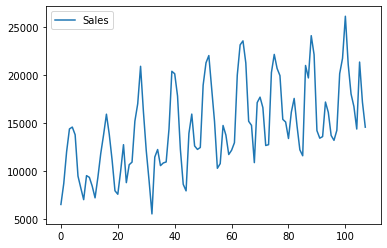

In [ ]:
# load and plot the car sales dataset
import matplotlib.pyplot as plt

# plot the time series
df.plot()
plt.show()

# We can clearly see from the output, the trend in sales over time and a monthly seasonal pattern to the sales. 
# These are patterns we expect the forecast model to take into account.

## **FORECAST Car Sales With PROPHET**
We will use Prophet to forecast the car sales dataset. 

Let’s start by fitting a model on the dataset.

### Fit Prophet Model

To use Prophet for forecasting, first, a Prophet() object is defined and configured, then it is fit on the dataset by calling the fit() function and passing the data.

The Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

The fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

This means we change the column names in the dataset. It also requires that the first column be converted to date-time objects, if they are not already.

For example, we can modify our loaded car sales dataset to have this expected structure, as follows:

In [ ]:
# prepare expected column names
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
df

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587
...,...,...
103,1968-08-01,16722
104,1968-09-01,14385
105,1968-10-01,21342
106,1968-11-01,17180


Prophet model:

In [ ]:
# fit prophet model on the car sales dataset

from fbprophet import Prophet

# define the model
model = Prophet()
# fit the model
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Make an **in-sample forecast**

It can be useful to make a forecast on historical data. That is, we can make a forecast on data used as input to train the model. Ideally, the model has seen the data before and would make a perfect prediction.

This is called making an in-sample (in training set sample) forecast.

A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted. 

In [ ]:
# There are many ways to create this DataFrame. In this case, we will loop over one year of dates, 
# e.g. the last 12 months in the dataset, and create a string for each month. We will then convert 
# the list of dates into a DataFrame and convert the string values into date-time objects.


# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

,ds
0,1968-01-01
1,1968-02-01
2,1968-03-01
3,1968-04-01
4,1968-05-01
5,1968-06-01
6,1968-07-01
7,1968-08-01
8,1968-09-01
9,1968-10-01


The result of the predict() function is a DataFrame that contains many columns. Perhaps the most important columns are the forecast date time (‘ds‘), the forecasted value (‘yhat‘), and the lower and upper bounds on the predicted value (‘yhat_lower‘ and ‘yhat_upper‘) that provide uncertainty of the forecast.

In [ ]:
# summarize the forecast
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# The first five months of the prediction are reported and we can see that values are not too 
# different from the actual sales values in the dataset.

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14334.737769  12713.201289  16011.270166
1 1968-02-01  14905.955964  13357.515834  16470.229033
2 1968-03-01  20842.150502  19282.274214  22530.626244
3 1968-04-01  22870.095215  21228.339620  24443.711034
4 1968-05-01  24176.211162  22618.465567  25747.054092


Prophet also provides a built-in tool for visualizing the prediction in the context of the training dataset.

This can be achieved by calling the plot() function on the model and passing it a result DataFrame. It will create a plot of the training dataset and overlay the prediction with the upper and lower bounds for the forecast dates.

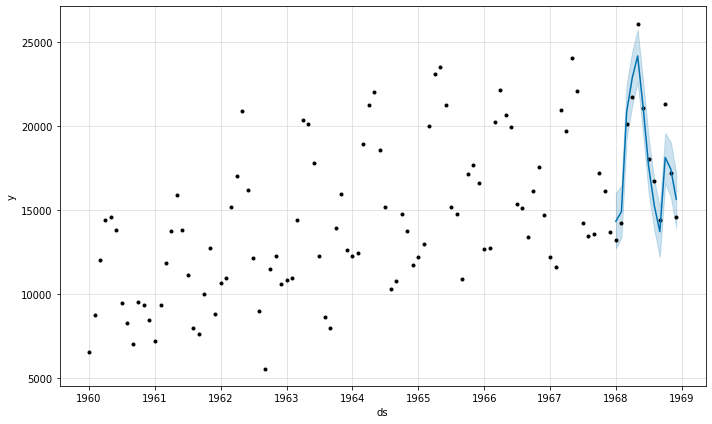

In [ ]:
# plot forecast
model.plot(forecast)
plt.show()

# In the plot, the training data are represented as black dots and the forecast is a blue line with upper and 
# lower bounds in a blue shaded area.

# We can see that the forecasted 12 months is a good match for the real observations, especially when the 
# bounds are taken into account.

### Make an **Out-of-Sample Forecast**

In practice, we really want a forecast model to make a prediction beyond the training data. This is called an out-of-sample forecast.

We can achieve this in the same way as an in-sample forecast and simply specify a different forecast period. 

In this case, let's choose a period beyond the end of the training dataset, starting 1969-01.

In [ ]:
# make an out-of-sample forecast

# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1969-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
future

,ds
0,1969-01-01
1,1969-02-01
2,1969-03-01
3,1969-04-01
4,1969-05-01
5,1969-06-01
6,1969-07-01
7,1969-08-01
8,1969-09-01
9,1969-10-01


In [ ]:
# use the model to make a forecast
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


# The first five rows of the forecast are printed, although it is hard to get an idea of whether they are sensible or not.

          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15375.960093  13752.240633  16990.171040
1 1969-02-01  16142.271673  14553.163519  17688.655797
2 1969-03-01  21351.832640  19765.096403  22969.164461
3 1969-04-01  23477.889811  22051.955051  25056.964038
4 1969-05-01  24988.440907  23446.679077  26534.424859


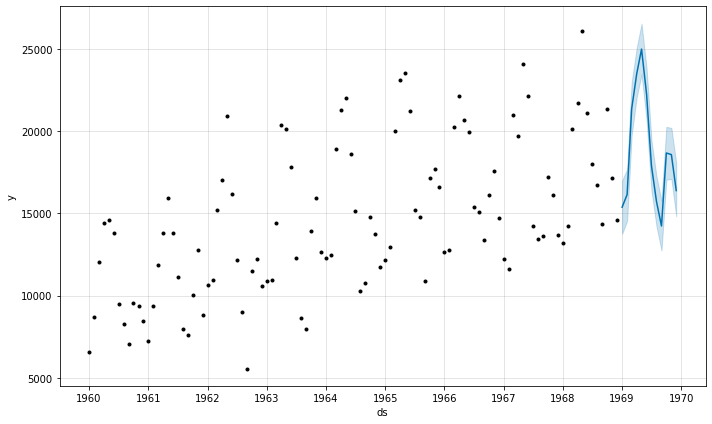

In [ ]:
# plot forecast
model.plot(forecast)
plt.show()

# The new one-year forecast does look sensible, at least by eye.

### Manually Evaluate Forecast Model


It is critical to develop an objective estimate of a forecast model’s performance.

This can be achieved by 
1. Holding some data back from the model, such as the last 12 months. 
2. Fitting the model on the first portion of the data. 
3. Using the model to make predictions on the held-pack portion
4. Calculating an error measure, such as the mean absolute error across the forecasts. 

**Evaluate a Prophet model on a hold-out dataset**

We can do this with the car sales data by creating a new DataFrame for training, with the last 12 months removed.

In [ ]:
# create test dataset, remove last 12 months
train = df.drop(df.index[-12:])
print(train.tail())

# Output reports the last few rows of the training dataset.
# It confirms the training ends in the last month of 1967 and 1968 will be used as the hold-out dataset.

           ds      y
91 1967-08-01  13434
92 1967-09-01  13598
93 1967-10-01  17187
94 1967-11-01  16119
95 1967-12-01  13713


A forecast can then be made on the last 12 months of date-times.

Then, we can retrieve the forecast values and the expected values from the original dataset and calculate a mean absolute error metric.

In [ ]:
from sklearn.metrics import mean_absolute_error

# calculate MAE between expected and predicted values for december
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)


# We can see that the output error is approximately 1,369 sales, 
# which is much lower (better) than a naive persistence model that 
# achieves an error of 3,235 sales over the same period.

MAE: 1369.485


Now, plot the expected vs. predicted values to see how well the out-of-sample prediction matches the known values.

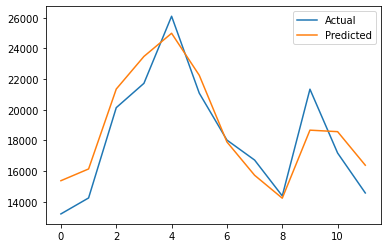

In [ ]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# We can see that the forecast is a good fit. The model has skill and forecast that looks sensible.

## Other Useful Resources

**Causal Time Series**

- https://towardsdatascience.com/inferring-causality-in-time-series-data-b8b75fe52c46

- https://github.com/WillianFuks/tfcausalimpact


**ARIMA**

- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

- https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8

**Prophet**

- https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274

- https://facebook.github.io/prophet/

- https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236

**Change point detection**

- https://medium.com/bigdatarepublic/dealing-with-abrupt-market-changes-in-your-analysis-a-brief-tutorial-on-time-series-change-point-3b624295afda

**TS Forecasting with deep learning**
https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/